#**Build Machine Learning Model Using PyCaret**
PyCaret is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment. With pycaret, we don't need to type a lot of rows of code. Just call the library and set the parameters, we will get the best accuracy for our model. 

Pycaret home page : **<i>https://pycaret.org/</i>**

In [1]:
#install the library
!pip install pycaret

     |████████████████████████████████| 256kB 5.7MB/s 
     |████████████████████████████████| 6.8MB 23.3MB/s 
     |████████████████████████████████| 1.7MB 44.5MB/s 
     |████████████████████████████████| 245kB 49.5MB/s 
     |████████████████████████████████| 14.2MB 323kB/s 
     |████████████████████████████████| 276kB 50.6MB/s 
     |████████████████████████████████| 1.8MB 34.8MB/s 
     |████████████████████████████████| 65.8MB 55kB/s 
     |████████████████████████████████| 174kB 49.7MB/s 
     |████████████████████████████████| 157.5MB 87kB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 3.1MB 36.6MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 604kB 51.6MB/s 
     |████████████████████████████████| 153kB 54.5MB/s 
     |████████████████████████████████| 1.1MB 46.7MB/s 
 

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret import  *

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
sns.set

import warnings
from google.colab import files
warnings.filterwarnings('ignore')

##**Pycaret Implementation on the Datathon_1**

**Read the Dataset**

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv")
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv')
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   agency                48260 non-null  object 
 1   agency_type           48260 non-null  object 
 2   distribution_channel  48260 non-null  object 
 3   product_name          48260 non-null  object 
 4   duration              48260 non-null  int64  
 5   destination           48260 non-null  object 
 6   net_sales             48260 non-null  float64
 7   commision             48260 non-null  float64
 8   gender                13899 non-null  object 
 9   age                   48260 non-null  int64  
 10  claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


**Rename the Comlumn**

In [5]:
df = df.rename(columns={'Agency':'agency', 'Agency Type':'agency_type','Distribution Channel':'distribution_channel','Product Name':'product_name',
           'Duration':'duration','Destination':'destination','Net Sales':'net_sales','Commision (in value)':'commision',
           'Gender':'gender','Age':'age','Claim':'claim'})

test_data = test_data.rename(columns={'Agency':'agency', 'Agency Type':'agency_type','Distribution Channel':'distribution_channel','Product Name':'product_name',
           'Duration':'duration','Destination':'destination','Net Sales':'net_sales','Commision (in value)':'commision','Gender':'gender','Age':'age'})

**Drop Gender**<br>
It is because the number of missing value more than 20%

In [7]:
df.drop("gender", axis=1, inplace=True)
test_data.drop("gender", axis=1, inplace=True)

**One Hot Encoding for Categorical Features (Nominal)**

In [8]:
#OHE on training data
ohe = OneHotEncoder(sparse=False)
df_encode = pd.DataFrame(ohe.fit_transform(df[['agency', 'agency_type', 'distribution_channel']]))
df_encode.columns = ohe.get_feature_names(['agency', 'agency_type', 'distribution_channel'])
df.drop(['agency', 'agency_type', 'distribution_channel'] ,axis=1, inplace=True)
df= pd.concat([df, df_encode], axis=1)
df.head()

#OHE on test data
ohe = OneHotEncoder(sparse=False)
test_encode = pd.DataFrame(ohe.fit_transform(test_data[['agency', 'agency_type', 'distribution_channel']]))
test_encode.columns = ohe.get_feature_names(['agency', 'agency_type', 'distribution_channel'])
test_data.drop(['agency', 'agency_type', 'distribution_channel'] ,axis=1, inplace=True)
test_data= pd.concat([test_data, test_encode], axis=1)
test_data.head()

,product_name,duration,destination,net_sales,commision,age,agency_ADM,agency_ART,agency_C2B,agency_CBH,agency_CCR,agency_CSR,agency_CWT,agency_EPX,agency_JWT,agency_JZI,agency_KML,agency_LWC,agency_RAB,agency_SSI,agency_TST,agency_TTW,agency_type_Airlines,agency_type_Travel Agency,distribution_channel_Offline,distribution_channel_Online
0,Cancellation Plan,24,HONG KONG,27.0,0.0,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,Cancellation Plan,51,JAPAN,45.0,0.0,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,Cancellation Plan,52,JAPAN,21.0,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,Cancellation Plan,89,SINGAPORE,11.0,0.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,Cancellation Plan,5,MALAYSIA,10.0,0.0,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


**Label Encoding for Categorical Features (Ordinal)**

In [9]:
labelencoder = LabelEncoder()
#data train
df.product_name = labelencoder.fit_transform(df.product_name)
df.destination = labelencoder.fit_transform(df.destination)
#data test
test_data.product_name = labelencoder.fit_transform(test_data.product_name)
test_data.destination = labelencoder.fit_transform(test_data.destination)

**Split the Dataset**

In [10]:
input = df.drop("claim", axis=1)
output = df.claim

x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.2, random_state=1, stratify=output)
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

**Outlier Handling**

In [11]:
#cek the outlier 
def outlier_check(data):
  q1, q3 = data.quantile(0.25), data.quantile(0.75)
  iqr = q3-q1
  return (q1-iqr*1.5), (q3+iqr*1.5)

#replace the ourlier with uperbound or lowerbound data
def iqr_replace(lb, ub, col,df):
  df.at[df[df[col]>ub].index.to_list(),col]= ub
  df.at[df[df[col]<lb].index.to_list(),col]= lb
  return df

#data without outlier
def clean_outlier(df, cols):
  df_to_clean = df.copy()
  for col in cols:
    lb, ub = outlier_check(df[col])
    df_to_clean = iqr_replace(lb, ub, col, df_to_clean)
  return df_to_clean

#Handling outlier using Z-score
def zscore_outlier(df, cols):
  for col in cols:
    mean, std = df[cols].mean(), df[cols].std()
    df['z_score'] = (df[cols]-mean)/std
    df = df[(df.z_score>-3) & (df.z_score<3)]
    df.reset_index(inplace=True)
    df.drop(['z_score','index'], axis=1, inplace=True)
  return df

In [12]:
train = zscore_outlier(train, ['duration'])
train = zscore_outlier(train, ['net_sales'])
train = zscore_outlier(train, ['commision'])
train = zscore_outlier(train, ['age'])
train.shape[0]

35297

**Data Normalization Using PowerTransformer**

In [13]:
pt = PowerTransformer()
norm_train = pd.DataFrame(pt.fit_transform(train[['duration', 'net_sales', 'commision', 'age']]), columns=['duration', 'net_sales', 'commision', 'age'])
train.drop(['duration', 'net_sales', 'commision', 'age'], axis=1, inplace=True)
train = pd.concat([train, norm_train], axis=1)
train.head()

,product_name,destination,agency_ADM,agency_ART,agency_C2B,agency_CBH,agency_CCR,agency_CSR,agency_CWT,agency_EPX,agency_JWT,agency_JZI,agency_KML,agency_LWC,agency_RAB,agency_SSI,agency_TST,agency_TTW,agency_type_Airlines,agency_type_Travel Agency,distribution_channel_Offline,distribution_channel_Online,claim,duration,net_sales,commision,age
0,1,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,-0.828127,3.041139,-0.795918,-0.161953
1,10,120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0.136656,-0.724280,-0.795918,1.915483
2,8,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,-0.554780,-0.217881,1.199764,1.454685
3,9,112,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.242659,0.306657,1.224090,-0.767742
4,9,112,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,-0.478960,0.346264,1.232829,2.059819


In [14]:
#normalization in test
norm_test = pd.DataFrame(pt.transform(test[['duration', 'net_sales', 'commision', 'age']]), columns=['duration', 'net_sales', 'commision', 'age'])
test.drop(['duration', 'net_sales', 'commision', 'age'], axis=1, inplace=True)
test.reset_index(inplace=True)
test = pd.concat([test, norm_test], axis=1)

#normalization in test data
norm_test_data = pd.DataFrame(pt.transform(test_data[['duration', 'net_sales', 'commision', 'age']]), columns=['duration', 'net_sales', 'commision', 'age'])
test_data.drop(['duration', 'net_sales', 'commision', 'age'], axis=1, inplace=True)
test_data = pd.concat([test_data, norm_test_data], axis=1)

**Data Scaling**

In [15]:
scale = StandardScaler()
scale_train = pd.DataFrame(scale.fit_transform(train[['duration', 'net_sales', 'commision', 'age','product_name','destination']]), columns=['duration', 'net_sales', 'commision', 'age','product_name','destination'])
train.drop(['duration', 'net_sales', 'commision', 'age','product_name','destination'], axis=1, inplace=True)
train = pd.concat([train, scale_train], axis=1)
train.head()

,agency_ADM,agency_ART,agency_C2B,agency_CBH,agency_CCR,agency_CSR,agency_CWT,agency_EPX,agency_JWT,agency_JZI,agency_KML,agency_LWC,agency_RAB,agency_SSI,agency_TST,agency_TTW,agency_type_Airlines,agency_type_Travel Agency,distribution_channel_Offline,distribution_channel_Online,claim,duration,net_sales,commision,age,product_name,destination
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,-0.828127,3.041139,-0.795918,-0.161953,-1.241458,-0.511641
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0.136656,-0.724280,-0.795918,1.915483,0.160933,0.974973
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,-0.554780,-0.217881,1.199764,1.454685,-0.150709,-0.767954
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.242659,0.306657,1.224090,-0.767742,0.005112,0.769923
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,-0.478960,0.346264,1.232829,2.059819,0.005112,0.769923


In [16]:
#scaling in test
scale_test = pd.DataFrame(scale.transform(test[['duration', 'net_sales', 'commision', 'age','product_name','destination']]), columns=['duration', 'net_sales', 'commision', 'age','product_name','destination'])
test.drop(['duration', 'net_sales', 'commision', 'age','product_name','destination'], axis=1, inplace=True)
test = pd.concat([test, scale_test], axis=1)

#scaling in test data
scale_test_data = pd.DataFrame(scale.transform(test_data[['duration', 'net_sales', 'commision', 'age','product_name','destination']]), columns=['duration', 'net_sales', 'commision', 'age','product_name','destination'])
test_data.drop(['duration', 'net_sales', 'commision', 'age','product_name','destination'], axis=1, inplace=True)
test_data = pd.concat([test_data, scale_test_data], axis=1)

In [17]:
x_test, y_test = test.drop("claim", axis=1), test.claim
x_test.drop('index', axis=1, inplace=True)

In [18]:
data = pd.concat([x_train, y_train], axis=1)
data_test = pd.concat([x_test, y_test], axis=1)
data = pd.concat([data, data_test])

In [19]:
data

,product_name,duration,destination,net_sales,commision,age,agency_ADM,agency_ART,agency_C2B,agency_CBH,agency_CCR,agency_CSR,agency_CWT,agency_EPX,agency_JWT,agency_JZI,agency_KML,agency_LWC,agency_RAB,agency_SSI,agency_TST,agency_TTW,agency_type_Airlines,agency_type_Travel Agency,distribution_channel_Offline,distribution_channel_Online,claim
23314,1.000000,8.000000,62.000000,112.000000,0.000000,36.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
23293,10.000000,24.000000,120.000000,14.000000,0.000000,59.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
18337,8.000000,11.000000,52.000000,26.000000,9.100000,53.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
46348,9.000000,27.000000,112.000000,39.000000,9.750000,31.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
8231,9.000000,12.000000,112.000000,40.000000,10.000000,61.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9647,1.095861,1.842077,0.872448,1.099008,1.556009,2.268598,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
9648,1.095861,0.275440,-1.998255,1.843723,1.603284,0.166758,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
9649,-1.397279,0.781846,0.436716,-0.467617,-0.795918,-0.161953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
9650,0.160933,-0.828127,-0.767954,-0.680915,-0.795918,-0.161953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0


**Pycaret Setup**

In [21]:
from pycaret.classification import *

In [22]:
"""
This is preprocessing process where we can apply some instruction for our data like
normalization, tranformation, ignore low variance, handle multicollinearity,
handle outlier, fix imbalance dataset, etc.
Note : type yes in the input field then press enter.
"""
s = setup(data = data, target='claim',normalize = True, 
          transformation = True, ignore_low_variance = True,
          remove_multicollinearity = True, multicollinearity_threshold = 0.95,
          session_id = 123, outliers_threshold = 0.05, fix_imbalance = True
           )

,Description,Value
0,session_id,123
1,Target,claim
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(48260, 27)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,20
8,Ordinal Features,False
9,High Cardinality Features,False


You can see what preprocessing process you used for this step in the result above. Like Fix Imbalance where the method is SMOTE. You can also set another operation for this steps. Just see the documentation! 

**Pycaret config code**

In [24]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [25]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fe78522dc80>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x7fe7852276a8>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7fe78523b1e0>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7fe78523b510>,make_scorer(matthews_corrcoef),pred,{},True,True,False


In [26]:
#remove the matrix
remove_metric('Kappa')
remove_metric('MCC')

In [27]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fe78522dc80>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x7fe7852276a8>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False


In [28]:
help(get_config)

Help on function get_config in module pycaret.classification:

get_config(variable:str)
    This function retrieves the global variables created when initializing the 
    ``setup`` function. Following variables are accessible:
    
    - X: Transformed dataset (X)
    - y: Transformed dataset (y)  
    - X_train: Transformed train dataset (X)
    - X_test: Transformed test/holdout dataset (X)
    - y_train: Transformed train dataset (y)
    - y_test: Transformed test/holdout dataset (y)
    - seed: random state set through session_id
    - prep_pipe: Transformation pipeline
    - fold_shuffle_param: shuffle parameter used in Kfolds
    - n_jobs_param: n_jobs parameter used in model training
    - html_param: html_param configured through setup
    - create_model_container: results grid storage container
    - master_model_container: model storage container
    - display_container: results display container
    - exp_name_log: Name of experiment
    - logging_param: log_experiment para

In [29]:
#show our train output
get_config('X_train')

,product_name,duration,destination,net_sales,commision,age,agency_C2B_1.0,agency_CWT_0.0,agency_EPX_1.0,agency_JZI_0.0,agency_type_Airlines_1.0
23150,1.770139,0.620398,0.967916,-0.662331,-0.211532,0.801806,0.0,1.0,0.0,1.0,1.0
31409,0.513375,-0.433101,0.199557,-0.515710,-0.698109,0.223212,0.0,1.0,1.0,1.0,0.0
5582,-1.134792,-1.175990,-1.308519,-0.914341,-0.965556,-1.633746,0.0,1.0,1.0,1.0,0.0
36431,0.513375,1.136061,-0.281398,-0.515710,-0.698109,0.223212,0.0,1.0,1.0,1.0,0.0
26782,0.513375,-1.016980,0.199557,-0.343575,-0.698109,0.223212,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
24361,-0.965546,1.277648,-0.806970,2.204276,-0.698109,0.223212,0.0,1.0,1.0,1.0,0.0
38491,0.242783,1.151842,-0.863439,0.257252,1.290735,-0.123425,0.0,1.0,0.0,0.0,1.0
4932,0.513375,0.488623,1.204069,-0.515710,-0.698109,-0.375721,0.0,1.0,1.0,1.0,0.0
47632,-0.400299,2.060720,0.967916,2.320917,1.857100,1.319916,1.0,1.0,0.0,1.0,1.0


**Build Machine Learning Model Using Pycaret**

In [30]:
best_model = compare_models(exclude=['rbfsvm','catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,TT (Sec)
rf,Random Forest Classifier,0.9615,0.7234,0.1082,0.0603,0.0773,7.347
et,Extra Trees Classifier,0.9570,0.7038,0.1383,0.0642,0.0875,4.407
dt,Decision Tree Classifier,0.9484,0.5508,0.1282,0.0467,0.0684,0.344
xgboost,Extreme Gradient Boosting,0.9465,0.7631,0.1965,0.0657,0.0983,9.716
lightgbm,Light Gradient Boosting Machine,0.9078,0.7891,0.3948,0.0656,0.1125,0.732
knn,K Neighbors Classifier,0.8775,0.6422,0.3206,0.0403,0.0717,0.684
svm,SVM - Linear Kernel,0.8396,0.0000,0.6413,0.0576,0.1057,0.257
ridge,Ridge Classifier,0.8374,0.0000,0.6373,0.0564,0.1037,0.069
lda,Linear Discriminant Analysis,0.8374,0.8078,0.6373,0.0565,0.1037,0.156
gbc,Gradient Boosting Classifier,0.8347,0.8021,0.6212,0.0544,0.1000,7.422


From this process, we can see that the best accuracy model produced by Random Forest, the best AUC produce by  Logistic Regression and F1 Score produced by Light GBM. So by using this library we can easily compare the accuracy of each model. So that we can decide which model will be used.

**Model Prediction**

In [31]:
predict = predict_model(best_model, data = test_data)

In [34]:
#this is the result
predict.head()

,agency_ADM,agency_ART,agency_C2B,agency_CBH,agency_CCR,agency_CSR,agency_CWT,agency_EPX,agency_JWT,agency_JZI,agency_KML,agency_LWC,agency_RAB,agency_SSI,agency_TST,agency_TTW,agency_type_Airlines,agency_type_Travel Agency,distribution_channel_Offline,distribution_channel_Online,duration,net_sales,commision,age,product_name,destination,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.136656,-0.176800,-0.795918,-0.161953,0.160933,-1.126791,0,0.94
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.818129,0.542980,-0.795918,-0.161953,0.160933,-0.870479,0,0.89
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.835742,-0.425571,-0.795918,-2.293743,0.160933,-0.870479,0,0.97
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.323104,-0.856106,-0.795918,-0.899126,0.160933,0.257297,0,0.99
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.215641,-0.900710,-0.795918,-0.515778,0.160933,-0.537272,0,1.00


**Optimizing Model for F1 Score Value**

In [35]:
lgbm = create_model('lightgbm', round = 2)

,Accuracy,AUC,Recall,Prec.,F1
0,0.90,0.76,0.36,0.06,0.10
1,0.90,0.76,0.41,0.06,0.11
2,0.91,0.79,0.42,0.07,0.12
3,0.90,0.81,0.30,0.05,0.08
4,0.91,0.76,0.38,0.06,0.11
5,0.91,0.84,0.52,0.09,0.15
6,0.92,0.79,0.34,0.06,0.11
7,0.91,0.77,0.38,0.07,0.11
8,0.90,0.79,0.38,0.06,0.10
9,0.91,0.82,0.46,0.08,0.13


In [36]:
tuned_lgbm = tune_model(lgbm, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1
0,0.8707,0.7747,0.5000,0.0572,0.1027
1,0.8653,0.7806,0.5306,0.0568,0.1026
2,0.8757,0.7983,0.5800,0.0678,0.1213
3,0.8644,0.8208,0.5000,0.0546,0.0984
4,0.8712,0.7691,0.4000,0.0471,0.0842
5,0.8760,0.8494,0.6400,0.0739,0.1325
6,0.8709,0.8145,0.5800,0.0653,0.1174
7,0.8745,0.8003,0.5600,0.0651,0.1167
8,0.8689,0.7904,0.5200,0.0584,0.1051
9,0.8754,0.8187,0.5200,0.0615,0.1099


In [50]:
x1 = data.iloc[300:400].drop('claim',axis=1)
y1 = data.iloc[300:400].claim

In [51]:
predict_new = predict_model(tuned_lgbm, data = x1)

Model Accuracy : 0.82%
Model F1_Score : 0.1

              precision    recall  f1-score   support

           0       0.96      0.84      0.90        96
           1       0.06      0.25      0.10         4

    accuracy                           0.82       100
   macro avg       0.51      0.55      0.50       100
weighted avg       0.93      0.82      0.87       100



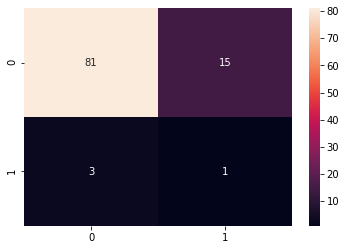

In [73]:
print("Model Accuracy : {0}%" .format(accuracy_score(y1, predict_new.Label)))
print("Model F1_Score : {0}\n" .format(f1_score(y1, predict_new.Label)))

print(classification_report(y1, predict_new.Label))
sns.heatmap(confusion_matrix(y1, predict_new.Label), annot=True, fmt='')
plt.show()

Although I have implemented imbalance data handling using smote, the model is not good enough.

##**Pycaret Implementation on the Datathon_2**

**Load the dataset**

In [74]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Heart_Disease/Training_set_heart.csv")
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Heart_Disease/Testing_set_heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48,1,2,124,255,1,1,175,0,0.0,2,2,2,1
1,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1
2,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
3,60,1,0,130,253,0,1,144,1,1.4,2,1,3,0
4,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1


**Setup Pycaret**

In [75]:
s = setup(data = df, target='target',normalize = True, 
          transformation = True, ignore_low_variance = True,
          remove_multicollinearity = True, multicollinearity_threshold = 0.95,
          session_id = 123, outliers_threshold = 0.05, fix_imbalance = True
           )

,Description,Value
0,session_id,123
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(212, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


**Get the best model**

In [76]:
best_model = compare_models( )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8252,0.8894,0.8339,0.8612,0.8316,0.6484,0.6720,0.467
catboost,CatBoost Classifier,0.8186,0.9204,0.8232,0.8532,0.8290,0.6355,0.6500,1.001
ridge,Ridge Classifier,0.8114,0.0000,0.8357,0.8284,0.8263,0.6200,0.6331,0.024
lr,Logistic Regression,0.8048,0.9031,0.8107,0.8448,0.8190,0.6074,0.6203,0.327
lda,Linear Discriminant Analysis,0.7976,0.8798,0.8482,0.8049,0.8185,0.5907,0.6077,0.025
rf,Random Forest Classifier,0.7914,0.8865,0.8107,0.8142,0.8037,0.5806,0.5931,0.474
lightgbm,Light Gradient Boosting Machine,0.7910,0.8659,0.8214,0.8154,0.8080,0.5774,0.5949,0.044
xgboost,Extreme Gradient Boosting,0.7848,0.8448,0.8107,0.8071,0.8024,0.5656,0.5756,1.871
nb,Naive Bayes,0.7843,0.8663,0.9232,0.7531,0.8234,0.5558,0.5842,0.023
gbc,Gradient Boosting Classifier,0.7781,0.8647,0.8232,0.7915,0.8010,0.5506,0.5614,0.088


**Build and evaluation mode using Extra Trees Classifier**

In [77]:
et = create_model('et', round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.87,0.86,1.00,0.80,0.89,0.73,0.76
1,0.80,0.89,0.88,0.78,0.82,0.59,0.60
2,0.80,0.92,1.00,0.73,0.84,0.59,0.64
3,0.80,0.89,0.75,0.86,0.80,0.60,0.61
4,0.87,0.91,0.88,0.88,0.88,0.73,0.73
5,0.73,0.77,0.88,0.70,0.78,0.45,0.47
6,0.73,0.82,0.50,1.00,0.67,0.48,0.56
7,0.87,0.96,0.88,0.88,0.88,0.73,0.73
8,0.86,0.87,0.71,1.00,0.83,0.71,0.75
9,0.93,1.00,0.88,1.00,0.93,0.86,0.87


**Optimize F1 Score**

In [78]:
tuned_et = tune_model(et, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8000,0.9107,0.7500,0.8571,0.8000,0.6018,0.6071
1,0.8000,0.8214,0.8750,0.7778,0.8235,0.5946,0.6001
2,0.8667,0.9464,0.8750,0.8750,0.8750,0.7321,0.7321
3,0.8000,0.8929,0.7500,0.8571,0.8000,0.6018,0.6071
4,0.8667,0.9107,0.8750,0.8750,0.8750,0.7321,0.7321
5,0.7333,0.8214,0.7500,0.7500,0.7500,0.4643,0.4643
6,0.8000,0.8929,0.7500,0.8571,0.8000,0.6018,0.6071
7,0.8000,0.9107,0.8750,0.7778,0.8235,0.5946,0.6001
8,0.8571,0.9184,0.8571,0.8571,0.8571,0.7143,0.7143
9,0.8571,1.0000,0.7500,1.0000,0.8571,0.7200,0.7500


**Predict New Data**

In [79]:
result = predict_model(tuned_et, data = test_data)
result.head(20)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Label,Score
0,46,0,0,138,243,0,0,152,1,0.0,1,0,2,0,0.5997
1,45,0,0,138,236,0,0,152,1,0.2,1,0,2,0,0.5951
2,59,1,3,160,273,0,0,125,0,0.0,2,0,2,1,0.8509
3,44,0,2,108,141,0,1,175,0,0.6,1,0,2,1,0.7600
4,47,1,2,108,243,0,1,152,0,0.0,2,0,2,1,0.9404
5,56,1,3,120,193,0,0,162,0,1.9,1,0,3,0,0.5568
6,70,1,0,130,322,0,0,109,0,2.4,1,3,2,0,0.6471
7,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,0.6944
8,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1,0.7548
9,46,1,2,150,231,0,1,147,0,3.6,1,0,2,1,0.7277


**How if we want to change the threshold for the probability?**<br>
If score < 0.6 : return 0 else: return 1

In [80]:
def get_new_value(x):
  num = 0
  if x > 0.6:
    num =1
  return num
result["new_result"] = result['Score'].apply(get_new_value)

In [81]:
result.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Label,Score,new_result
0,46,0,0,138,243,0,0,152,1,0.0,1,0,2,0,0.5997,0
1,45,0,0,138,236,0,0,152,1,0.2,1,0,2,0,0.5951,0
2,59,1,3,160,273,0,0,125,0,0.0,2,0,2,1,0.8509,1
3,44,0,2,108,141,0,1,175,0,0.6,1,0,2,1,0.7600,1
4,47,1,2,108,243,0,1,152,0,0.0,2,0,2,1,0.9404,1


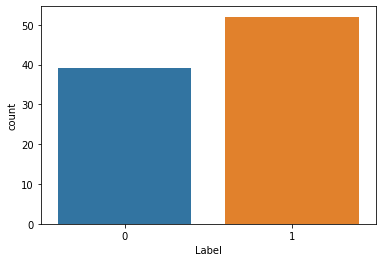

In [83]:
sns.countplot(result.Label);

**To CSV**

In [ ]:
resultcsv = pd.DataFrame({'prediction':result.new_result.to_list()})
resultcsv.to_csv("pycaret3.csv", index= False)
files.download('pycaret3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>